In [2]:
import surveysim as ssim

import geopandas as gpd
from scipy.stats._distn_infrastructure import rv_frozen


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Build `Area`

### From shapefile

In [3]:
area = ssim.Area.from_shapefile('test_area', '../tests/test_datasets/shapefiles/areas/leiap_field1.shp')

{'name': 'test_area',
 'vis': 1.0,
 'vis_type': 'scalar',
 'shape': <shapely.geometry.polygon.Polygon at 0x1a29480e48>,
 'df':    area_name  vis                                           geometry
 0  test_area  1.0  POLYGON ((533545.664 4388841.881, 533546.214 4...}

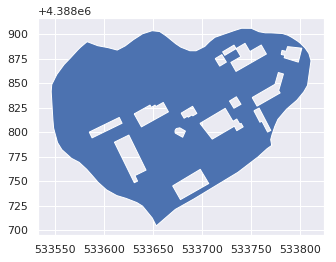

In [4]:
area.df.plot();
area.__dict__

### Set visibility to beta distribution

In [5]:
area.set_vis_beta_dist(alpha=9, beta=1)

/Users/jacobdeppen/miniconda3/envs/model/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


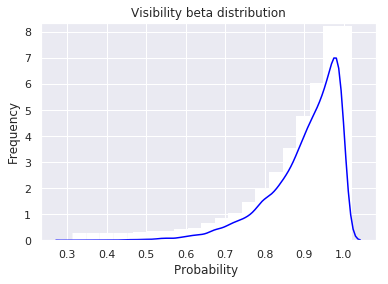

In [6]:
ax = sns.distplot(area.vis.rvs(10000),
                  bins=20,
                  kde=True,
                  hist_kws={"linewidth": 15,'alpha':1},
                  kde_kws={'color':'blue'}
                 )
ax.set(title='Visibility beta distribution', xlabel='Probability ', ylabel='Frequency');

In [7]:
area.df

,area_name,vis,geometry
0,test_area,<scipy.stats._distn_infrastructure.rv_frozen o...,"POLYGON ((533545.664 4388841.881, 533546.214 4..."


## Build `Layers`

### Poisson point process

In [8]:
ceramics = ssim.Layer.from_poisson_points(rate=.001, area=area, name='ceramics')

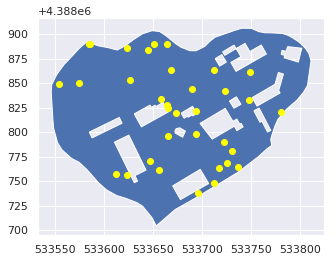

In [9]:
ceramics.df.plot(ax=area.df.plot(), color='yellow');


#### Update ideal observation rate of `ceramics`

In [10]:
ceramics.set_ideal_obs_rate_beta_dist(alpha=9.5, beta=0.5)

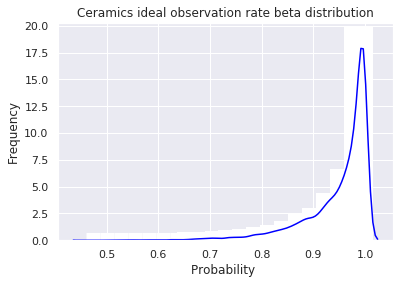

In [11]:
ax = sns.distplot(ceramics.ideal_obs_rate.rvs(10000),
                  bins=20,
                  kde=True,
                  hist_kws={"linewidth": 15,'alpha':1},
                  kde_kws={'color':'blue'}
                 )
ax.set(title='Ceramics ideal observation rate beta distribution', xlabel='Probability ', ylabel='Frequency');

#### Update time penalty of `ceramics`

When a ceramic artifact is collected, how much time does that add (in seconds) to the collection time? Here we imagine that the mean time added by one artifact is 60 seconds, but that the standard deviation is also 60 seconds. The minimum time that must be added is 10 seconds and the maximum is 600 seconds.

In [12]:
ceramics.set_time_penalty_truncnorm_dist(mean=60, sd=60, lower=10, upper=600)

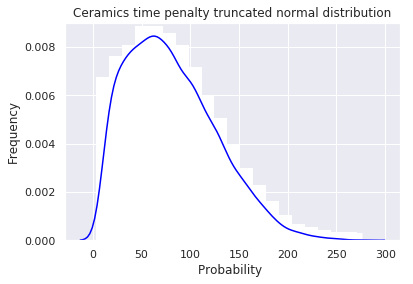

In [13]:
ax = sns.distplot(ceramics.time_penalty.rvs(10000),
                  bins=20,
                  kde=True,
                  hist_kws={"linewidth": 15,'alpha':1},
                  kde_kws={'color':'blue'}
                 )
ax.set(title='Ceramics time penalty truncated normal distribution', xlabel='Probability ', ylabel='Frequency');

In [14]:
ceramics.df.head()

,layer_name,fid,time_penalty,ideal_obs_rate,geometry
1,ceramics,ceramics_1,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533665.5452217374 4388795.809345735)
2,ceramics,ceramics_2,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533668.9565984783 4388863.094693985)
4,ceramics,ceramics_4,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533747.7835831095 4388832.319335232)
5,ceramics,ceramics_5,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533723.4146577716 4388841.800819298)
9,ceramics,ceramics_9,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533748.928861381 4388861.621135675)


### Thomas point process

In [15]:
lithics = ssim.Layer.from_thomas_points(
    parent_rate=0.001, child_rate=5, gauss_var=5, area=area, name='lithics')

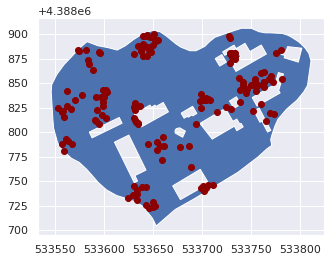

In [16]:
lithics.df.plot(ax=area.df.plot(), color='darkred');

#### Update time penalty 
...but do not update ideal observation rate. This would presume that lithic artifacts are easy to see.

In [17]:
lithics.set_time_penalty_truncnorm_dist(mean=20, sd=5, lower=5, upper=40)

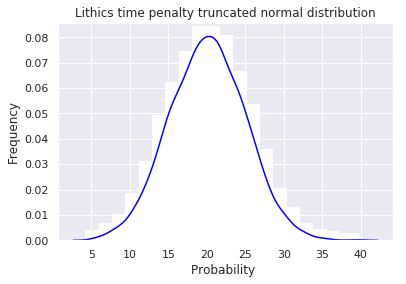

In [18]:
ax = sns.distplot(lithics.time_penalty.rvs(10000),
                  bins=20,
                  kde=True,
                  hist_kws={"linewidth": 15,'alpha':1},
                  kde_kws={'color':'blue'}
                 )
ax.set(
    title='Lithics time penalty truncated normal distribution', 
    xlabel='Probability ', ylabel='Frequency');

In [19]:
lithics.df.head()

,layer_name,fid,time_penalty,ideal_obs_rate,geometry
0,lithics,lithics_0,<scipy.stats._distn_infrastructure.rv_frozen o...,1.0,POINT (533741.6760859049 4388851.344419431)
1,lithics,lithics_1,<scipy.stats._distn_infrastructure.rv_frozen o...,1.0,POINT (533741.5307962127 4388847.820619631)
2,lithics,lithics_2,<scipy.stats._distn_infrastructure.rv_frozen o...,1.0,POINT (533737.7702757543 4388854.908805331)
3,lithics,lithics_3,<scipy.stats._distn_infrastructure.rv_frozen o...,1.0,POINT (533738.3957527545 4388842.870258237)
4,lithics,lithics_4,<scipy.stats._distn_infrastructure.rv_frozen o...,1.0,POINT (533750.5677652023 4388847.968014117)


### Matern point process
Set time penalty as a scalar (8 seconds) during creation

In [20]:
ground_stone = ssim.Layer.from_matern_points(
    parent_rate=0.001, child_rate=5, radius=15, 
    area=area, name='ground stone', time_penalty=8
)

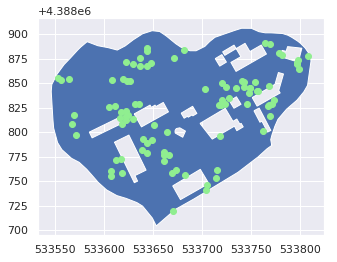

In [21]:
ground_stone.df.plot(ax=area.df.plot(), color='lightgreen');

#### Update ideal observation rate

In [22]:
ground_stone.set_ideal_obs_rate_beta_dist(alpha=9.9, beta=0.1)

In [23]:
ground_stone.df.head()

,layer_name,fid,time_penalty,ideal_obs_rate,geometry
4,ground stone,ground stone_4,8,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533715.8514805185 4388761.105035696)
6,ground stone,ground stone_6,8,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533720.9404258978 4388832.524850463)
7,ground stone,ground stone_7,8,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533728.0353105707 4388834.824602819)
8,ground stone,ground stone_8,8,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533719.1446461315 4388827.290150754)
9,ground stone,ground stone_9,8,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533703.0409881617 4388843.868419582)


### Points from a shapefile

In [24]:
coins = ssim.Layer.from_shapefile(path='../tests/test_datasets/shapefiles/layers/leiap_field1_points.shp', 
                                 area=area, name='coins', feature_type='points')

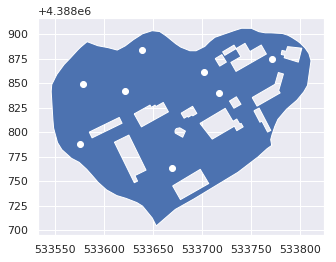

In [25]:
coins.df.plot(ax=area.df.plot(), color='white');

### Pseudorandom point process

In [26]:
tile = ssim.Layer.from_pseudorandom_points(n=15, area=area, name='tile')

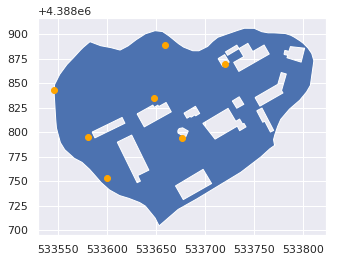

In [27]:
tile.df.plot(ax=area.df.plot(), color='orange');

### Plot all `Layer` objects

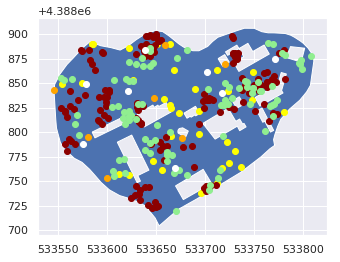

In [28]:
area_ax = area.df.plot()
ceramics.df.plot(ax=area_ax, color='yellow')
lithics.df.plot(ax=area_ax, color='darkred')
ground_stone.df.plot(ax=area_ax, color='lightgreen')
coins.df.plot(ax=area_ax, color='white')
tile.df.plot(ax=area_ax, color='orange');

## Compile `Layers` into `Assemblage`

In [29]:
assemblage = ssim.Assemblage(
    name='test_assemblage', 
    layers=[ceramics, lithics, ground_stone, coins, tile]
)

In [30]:
assemblage.df.head()

,layer_name,fid,time_penalty,ideal_obs_rate,geometry
0,ceramics,ceramics_1,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533665.5452217374 4388795.809345735)
1,ceramics,ceramics_2,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533668.9565984783 4388863.094693985)
2,ceramics,ceramics_4,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533747.7835831095 4388832.319335232)
3,ceramics,ceramics_5,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533723.4146577716 4388841.800819298)
4,ceramics,ceramics_9,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533748.928861381 4388861.621135675)


In [31]:
assemblage.df.shape

(290, 5)

In [32]:
assemblage.df['layer_name'].unique()

array(['ceramics', 'lithics', 'ground stone', 'coins', 'tile'],
      dtype=object)

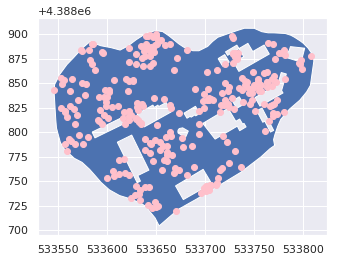

In [33]:
assemblage.df.plot(ax=area.df.plot(), color='pink');

## Build `Coverage`

In [34]:
transects = ssim.Coverage.make_transects(
    area=area, name='transects', spacing=20, sweep_width=2, 
    optimize_orient_by='area_orient', orient_axis='short',
    min_time_per_unit=0.5
)

In [35]:
transects.df.head()

,su_id,area,base_search_time,length,sweep_width,geometry
0,0,543.933425,70.069494,140.138988,2,(POLYGON ((533658.1146908473 4388709.590210016...
1,1,593.165096,74.291707,148.583414,2,(POLYGON ((533673.3662457999 4388722.767565872...
2,2,595.498503,74.791650,149.583301,2,(POLYGON ((533691.6858272522 4388733.177950755...
3,3,705.085913,88.816972,177.633943,2,"(POLYGON ((533709.58024857 4388743.971776181, ..."
4,4,704.968549,87.809033,175.618065,2,(POLYGON ((533727.4448748676 4388754.792472938...


In [36]:
transects.n_survey_units

12

In [37]:
transects.spacing

20

In [38]:
transects.survey_unit_type

'transect'

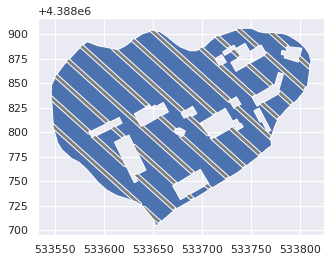

In [39]:
transects.df.plot(ax=area.df.plot(), color='gray');

In [40]:
transects.orientation

47.95354531912556

## Build `Team`

### Create `Surveyor` objects

First, add a "perfect" surveyor, who we'll call an expert

In [41]:
pi = ssim.Surveyor(name='Vivienne', surveyor_type='PI', skill=1.0, speed_penalty=0)

In [42]:
pi.df

,surveyor_name,surveyor_type,skill,speed_penalty
0,Vivienne,PI,1.0,0


In [43]:
grad1 = ssim.Surveyor(name='Dennis', surveyor_type='grad_student')
grad1.df

,surveyor_name,surveyor_type,skill,speed_penalty
0,Dennis,grad_student,1.0,0.0


Reduce the skill level just slightly for the grad student. Leave the `speed_penalty` at 0 because this student has a lot of experience with this methodology.

In [44]:
grad1.set_skill_beta_dist(alpha=9.5, beta=0.5)
grad1.df

,surveyor_name,surveyor_type,skill,speed_penalty
0,Dennis,grad_student,<scipy.stats._distn_infrastructure.rv_frozen o...,0.0


In [45]:
grad2 = ssim.Surveyor(name='Alex', surveyor_type='grad_student')
grad2.set_skill_beta_dist(alpha=9.5, beta=0.5)

Add a `speed_penalty` to this grad student who is unfamiliar with the methodology. Mean penalty is 60 seconds, with a wide standard deviation. Penalty cannot go below zero or above 300 seconds (5 minutes)

In [46]:
grad2.set_speed_penalty_truncnorm_dist(mean=60, sd=100, lower=0, upper=300)

The distribution of `speed_penalty` values for grad2 would look something like this.

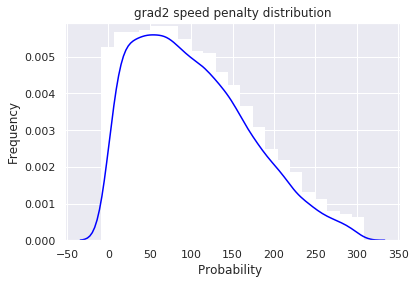

In [47]:
ax = sns.distplot(grad2.speed_penalty.rvs(10000),
                  bins=20,
                  kde=True,
                  hist_kws={"linewidth": 15,'alpha':1},
                  kde_kws={'color':'blue'}
                 )
ax.set(title='grad2 speed penalty distribution', xlabel='Probability ', ylabel='Frequency');

In [48]:
undergrad1 = ssim.Surveyor(name='Robert', surveyor_type='undergrad')
undergrad1.set_skill_beta_dist(alpha=8, beta=2)
undergrad1.set_speed_penalty_truncnorm_dist(mean=90, sd=100, lower=0, upper=300)

In [49]:
undergrad2 = ssim.Surveyor(name='Faye', surveyor_type='undergrad')
undergrad2.set_skill_beta_dist(alpha=6.5, beta=3.5)
undergrad2.set_speed_penalty_truncnorm_dist(mean=110, sd=100, lower=0, upper=400)

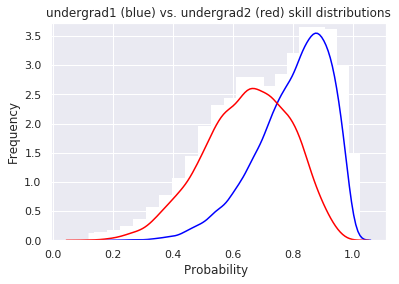

In [50]:
ax = sns.distplot(undergrad1.skill.rvs(10000),
                  bins=20,
                  kde=True,
                  hist_kws={"linewidth": 15,'alpha':1},
                  kde_kws={'color':'blue'}
                 )

sns.distplot(undergrad2.skill.rvs(10000),
                  bins=20,
                  kde=True,
                  hist_kws={"linewidth": 15,'alpha':1},
                  kde_kws={'color':'red'}
                 )
ax.set(title='undergrad1 (blue) vs. undergrad2 (red) skill distributions', xlabel='Probability ', ylabel='Frequency');

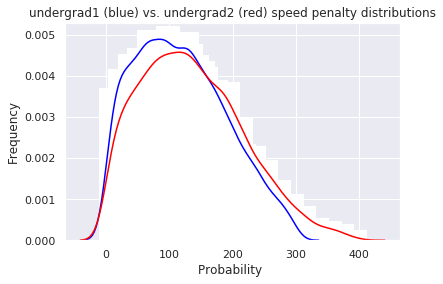

In [51]:
ax = sns.distplot(undergrad1.speed_penalty.rvs(10000),
                  bins=20,
                  kde=True,
                  hist_kws={"linewidth": 15,'alpha':1},
                  kde_kws={'color':'blue'}
                 )

sns.distplot(undergrad2.speed_penalty.rvs(10000),
                  bins=20,
                  kde=True,
                  hist_kws={"linewidth": 15,'alpha':1},
                  kde_kws={'color':'red'}
                 )
ax.set(title='undergrad1 (blue) vs. undergrad2 (red) speed penalty distributions', xlabel='Probability ', ylabel='Frequency');

In [52]:
team = ssim.Team(name='invincibles', surveyors=[pi, grad1, grad2, undergrad1, undergrad2])

In [53]:
team.df

,surveyor_name,surveyor_type,skill,speed_penalty
0,Vivienne,PI,1,0
1,Dennis,grad_student,<scipy.stats._distn_infrastructure.rv_frozen o...,0
2,Alex,grad_student,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...
3,Robert,undergrad,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...
4,Faye,undergrad,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...


## One run of the `Simulation`

### Notes on compiling outputs

In [66]:
assemblage.df.head()

,layer_name,fid,time_penalty,ideal_obs_rate,geometry
0,ceramics,ceramics_1,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533665.5452217374 4388795.809345735)
1,ceramics,ceramics_2,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533668.9565984783 4388863.094693985)
2,ceramics,ceramics_4,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533747.7835831095 4388832.319335232)
3,ceramics,ceramics_5,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533723.4146577716 4388841.800819298)
4,ceramics,ceramics_9,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533748.928861381 4388861.621135675)


In [67]:
assemblage.name

'test_assemblage'

# `assemblage_out`

For each artifact or feature, record:
- Did it intersect a survey unit? `True` or `False`
- What was the `su_id` of the survey unit?
- ~~Who was the surveyor for that survey unit?~~
- What was the visibility value (inherited scalar or value from distribution/raster)?
- What was the ideal observation rate (inherited scalar or value from distribution)?
- What was the surveyor skill (inherited scalar or value from distribution)?
- How much time did it add on to the survey unit (inherited scalar or value from distribution)?
- (What was the distance factor?)
- What is the probability of discovery and recording? (viz * IOR * skill [* distance_factor])

#### `coverage_out`

For each survey unit, record:
- Who was the surveyor?
- How many artifacts intersected?
- How many artifacts were actually discovered and recorded?
- What was the base search time?
- What is the total time penalty from artifacts/features (sum of inherited scalars or values from distribution)?
- What is the speed penalty for the surveyor (inherited scalar or value from distribution)?
- What is the total search time after accounting for artifacts/features?

1. Intersection - `True` or `False`
2. Visibility - pull from `Area`
3. Ideal obs rate - pull from self
4. Surveyor skill - pull from `Team`

fill out `NaN` values for artifacts that were not found

### Find shapes from the `Assemblage` that intersect at least part of the `Coverage`

In [55]:
assemblage.df.shape

(290, 5)

In [56]:
transects.df.shape

(12, 6)

In [57]:
artifacts_in_coverage = gpd.sjoin(assemblage.df, transects.df, how='inner', op='intersects')

In [58]:
artifacts_in_coverage.shape

(52, 11)

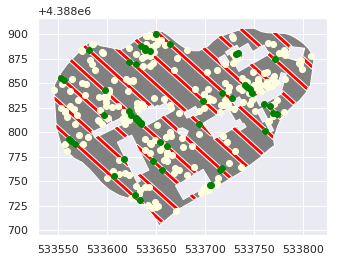

In [59]:
ax = transects.df.plot(ax=area.df.plot(color='gray'), color='red')
assemblage.df.plot(ax=ax, color='lightyellow')
artifacts_in_coverage.plot(ax=ax, color='green');

In [60]:
artifacts_in_coverage.head()

,layer_name,fid,time_penalty,ideal_obs_rate,geometry,index_right,su_id,area,base_search_time,length,sweep_width
9,ceramics,ceramics_19,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533664.7128846091 4388889.487672173),7,7,618.234091,77.209376,154.418753,2
163,lithics,lithics_260,<scipy.stats._distn_infrastructure.rv_frozen o...,1,POINT (533650.6898264406 4388899.79715391),7,7,618.234091,77.209376,154.418753,2
184,ground stone,ground stone_7,8,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533728.0353105707 4388834.824602819),7,7,618.234091,77.209376,154.418753,2
266,ground stone,ground stone_169,8,<scipy.stats._distn_infrastructure.rv_frozen o...,POINT (533761.8600381584 4388800.854725526),7,7,618.234091,77.209376,154.418753,2
282,coins,coins_7,0,1,POINT (533717.918364095 4388839.909503635),7,7,618.234091,77.209376,154.418753,2


### Assign a `surface_visibility` to all `artifacts_in_coverage` from `Area` scalar or pull from distribution

In [61]:
if area.vis_type == 'distribution':
    # draw len(artifacts_in_coverage) samples from distribution
    pass
elif area.vis_type == 'scalar':
    # assign scalar value to all artifacts_in_coverage
    pass
elif area.vis_type == 'raster':
    # do complicated raster stuff
    pass
else:
    # raise error

SyntaxError: unexpected EOF while parsing (<ipython-input-61-22fa206d8c1f>, line 11)